# Hires, Gutnisky et al., 2015 - A DataJoint example

This notebook presents data and results associated with the following papers:
>Samuel Andrew Hires, Diego A Gutnisky, Jianing Yu, Daniel H O’Connor, and Karel Svoboda. "Low-noise encoding of active touch by
layer 4 in the somatosensory cortex" (2015) eLife (http://doi.org/10.7554/eLife.06619)

This study investigated the spiking variability of layer 4 (L4) excitatory neurons in the mouse barrel cortex, using intracellular recordings. The recordings were performed during a object locating task, where whisker movements and contacts with object were tracked to the milisecond precision. Spiking patterns in L4 neurons appeared irregular at first, however upon alingning to the fine-scale structure of the behavior, the study revealed that spiking patterns are coupled to the temporal sensory input from object contact, with spike rate increases shortly after touch.

A ***DataJoint*** data pipeline has been constructed for this study, with the presented data ingested into this pipeline. This notebook demonstrates the queries, processing, and reproduction of several figures from the paper. From the pipeline, export capability to NWB 2.0 format is also available.

## About the data

The dataset comprises of membrane potential, and spikes of layer 4 (L4) neurons of the mouse's barrel cortex (around C2 column) during a whisker-based object locating task. The behavior data includes detailed description of the trial structure (e.g. trial timing, trial instruction, trial response, etc.) and a variety of whisker movement related tracking data: whisker position, whisker phase, whisker curvature change, touch times, etc.

Original data can be found here: http://crcns.org/data-sets/ssc/ssc-5/about-ssc-5

The data in original MATLAB format (.mat) have been ingested into a DataJoint data pipeline presented below. This notebook demonstrates the queries, processing, and reproduction of several figures from the paper. 

Data are also exported into NWB 2.0 format. The code used for performing NWB export can be found [here](../scripts/datajoint_to_nwb.py)

In [2]:
# import necessary Python packages including DataJoint

from datetime import datetime
import os
os.chdir('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import datajoint as dj
from pipeline import (reference, subject, acquisition, stimulation, analysis, virus,
                      intracellular, behavior, utilities)

Connecting root@127.0.0.1:3306


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Architecture of the data pipeline

This data pipeline is comprised of three core components:
+ **subject**: the meta information on the animal, e.g. genetic information, virus injection
+ **acquisition**: the organization of the experiment: session acquisition, trial structure, behavior data
+ **electrophysiology**: intracellular recordings, and spikes data

In DataJoint, related tables are organized together into a **schema**, and a data pipeline typically consists of tables across multiple schemas connected to each other.

### Subject

`subject` schema contains various tables representing information and meta-information about the experimental animals, as well as information about genetic backgrounds and virus injected for the experiment. The DataJoint *Diagram* below shows all tables found inside the `subject` schema.

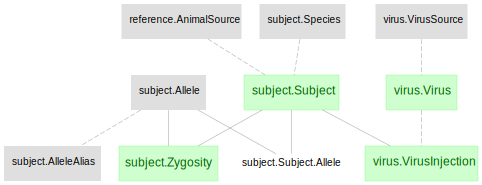

In [3]:
dj.Diagram(subject) - 1 + dj.Diagram(virus)

For example, `Subject` table contains information about each and every mouse in the experiment, capturing information such as unique subject ID and animal sourcce.

In [4]:
subject.Subject()

subject_id id of the subject (e.g. ANM244028),species,"animal_source source of the animal, Jax, Charles River etc.",sex,date_of_birth,subject_description
anm101105,mus musculus,N/A,U,None,None
anm106211,mus musculus,N/A,U,None,None
anm106213,mus musculus,N/A,U,None,None
anm131970,mus musculus,N/A,U,None,None
anm134333,mus musculus,N/A,U,None,None
anm17702,mus musculus,N/A,U,None,None
anm211295,mus musculus,Jackson,U,None,None


### Experiment acquisition

Information pertaining to conducting the experiment as well as data and meta-data acquired during the experiment (except for electrophysiology) are found among three schemas: `acquisition`, `stimulation` and `behavior`. Below, tables across all three schemas are depicted in the DataJoint Diagram.

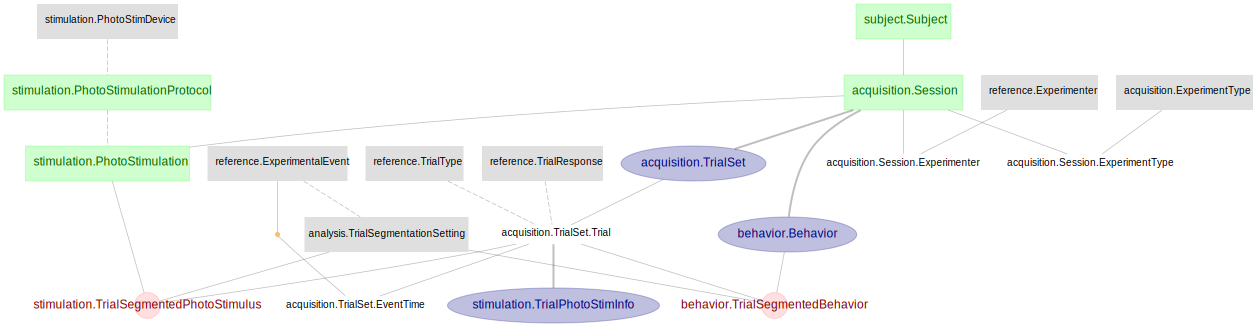

In [5]:
dj.Diagram(acquisition) - 1 + dj.Diagram(stimulation) + dj.Diagram(behavior)

`Session` tables contains information about individual experiment session.

In [8]:
acquisition.Session.proj() * subject.Subject

subject_id id of the subject (e.g. ANM244028),session_time session time,session_id,species,"animal_source source of the animal, Jax, Charles River etc.",sex,date_of_birth,subject_description
anm101105,2010-06-19 00:00:00,Cell46,mus musculus,N/A,U,None,None
anm101105,2010-06-20 00:00:00,Cell47,mus musculus,N/A,U,None,None
anm101105,2010-06-21 00:00:00,Cell48,mus musculus,N/A,U,None,None
anm106211,2010-09-25 00:00:00,Cell17,mus musculus,N/A,U,None,None
anm106213,2010-08-22 00:00:00,Cell49,mus musculus,N/A,U,None,None
anm106213,2010-12-14 00:00:00,Cell50,mus musculus,N/A,U,None,None
anm106213,2010-12-15 00:00:00,Cell32,mus musculus,N/A,U,None,None


`Trial` table (found as part table of `TrialSet`) contains information about each trial.

In [9]:
acquisition.TrialSet.Trial()

subject_id id of the subject (e.g. ANM244028),session_time session time,session_id,trial_id id of this trial in this trial set,"start_time start time of this trial, with respect to starting point of this session","stop_time end time of this trial, with respect to starting point of this session",trial_type,trial_response,trial_stim_present is this a stim or no-stim trial,pole_position (um) the location of the pole along the anteroposterior axis of the animal
anm101105,2010-06-19 00:00:00,Cell46,13,0.0001,4.501,Nogo,CR,0,10912.0
anm101105,2010-06-19 00:00:00,Cell46,14,5.32676,9.82766,Go,Hit,0,4960.0
anm101105,2010-06-19 00:00:00,Cell46,15,12.1176,16.6185,Nogo,CR,0,10912.0
anm101105,2010-06-19 00:00:00,Cell46,16,17.4474,21.9483,Go,Miss,0,4960.0
anm101105,2010-06-19 00:00:00,Cell46,17,22.7742,27.2751,Nogo,CR,0,10912.0
anm101105,2010-06-19 00:00:00,Cell46,18,28.1198,32.6207,Go,Hit,0,4960.0
anm101105,2010-06-19 00:00:00,Cell46,19,34.89,39.3909,Go,Hit,0,4960.0


### Electrophysiology

Electrophysiology information are in the `intracellular` schema

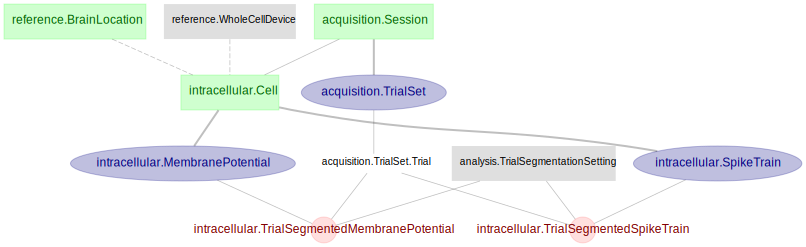

In [3]:
dj.Diagram(intracellular) - 1

As an example of intracellular recording, the `intracellular.Cell` table contains information of all the recorded cell (e.g. which brain region, cell depth, cell type, etc.)

In [13]:
intracellular.Cell * reference.BrainLocation

subject_id id of the subject (e.g. ANM244028),session_time session time,session_id,cell_id a string identifying the cell in which this intracellular recording is concerning,brain_region,brain_subregion,cortical_layer layer within cortex,hemisphere,cell_type,recording_depth (um),device_name,brain_location_full_name
anm106211,2010-09-25 00:00:00,Cell17,AH0062_AAAA,barrel,C2,4,left,excitatory,528.00,Borosilicate glass,"S1, barrel field, Paxinos"
anm17702,2010-05-07 00:00:00,Cell27,AH0026_AAAA,barrel,C2,4,left,excitatory,410.00,Borosilicate glass,"S1, barrel field, Paxinos"
anm215592,2013-10-15 00:00:00,Cell09,AH1001_AAAA,barrel,C2,4,left,excitatory,471.00,Borosilicate glass,"S1, barrel field, Paxinos"
anm215592,2013-10-15 00:00:00,Cell28,AH1001_AAAA,barrel,C2,4,left,excitatory,439.00,Borosilicate glass,"S1, barrel field, Paxinos"
anm215592,2013-10-23 00:00:00,Cell10,AH1012_AAAA,barrel,C2,4,left,excitatory,560.00,Borosilicate glass,"S1, barrel field, Paxinos"
anm226694,2014-02-22 00:00:00,Cell12,AH1045_AAAA,barrel,C2,4,left,excitatory,444.00,Borosilicate glass,"S1, barrel field, Paxinos"
anm226694,2014-02-22 00:00:00,Cell31,AH1047_AAAA,barrel,C2,4,left,excitatory,547.00,Borosilicate glass,"S1, barrel field, Paxinos"


## Reproduced analysis and figures

To demonstrate the availability and usage of the data in the pipeline, the following sections of this notebook will show the extraction and plotting of several sets of tracking and ephys data of interest, specifically, we will reproduce **Figure 1** and **Figure 2** of this study.

### Reproducing Figure 1

### Figure 1B

Figure 1B shows the ephys and behavior data for one representative trial and cell. To reproduce, we will need to:
1. select a cell and a trial
2. extract ephys and behavior data (trial-segmented)
3. plot

First, we select a representative cell recording session - "Cell 23"

In [4]:
session_key = acquisition.Session & 'session_id="Cell23"'

Then we pick an example trial from the selected session - trial 78

In [5]:
trial_key = acquisition.TrialSet.Trial & session_key & 'trial_id=78'

Next, select a particuclar setting defining how to segment out information per trial, including the definition of even for alignment

here we choose segmentation setting to align to `trial_start` event

In [6]:

seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'trial_start',
                                                      'pre_stim_duration': 0,
                                                      'post_stim_duration': 4.9}).fetch1()

Then extract membrane potential for this cell and trial

In [7]:
# Get segmented Membrane Potential
mp, ephys_timestamps = (intracellular.TrialSegmentedMembranePotential & trial_key & seg_param_key).fetch1('segmented_mp', 'segmented_mp_timestamps')
behav = (behavior.TrialSegmentedBehavior & trial_key & seg_param_key).fetch1()
behav_timestamps = behav['segmented_behavior_timestamps']

Finally, we plot

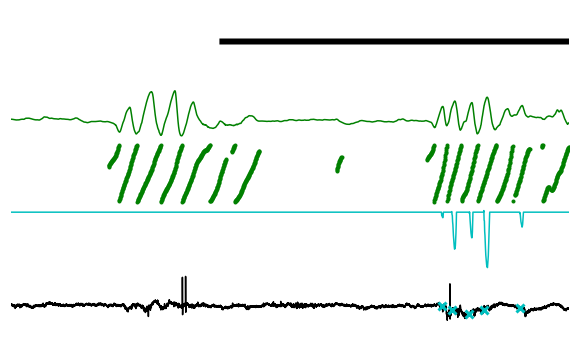

In [8]:
fig1a, axs = plt.subplots(5, 1, figsize=(10, 6))
fig1a.subplots_adjust(hspace=0.05)
axs[0].plot(behav_timestamps, np.where(behav['segmented_pole_available'] > 0, behav['segmented_pole_available'], np.nan), 'k',
           linewidth=6)
axs[1].plot(behav_timestamps, behav['segmented_theta_at_base'], 'g')
axs[2].plot(behav_timestamps, np.where(behav['segmented_amplitude'] > 2.5, behav['segmented_phase'], np.nan), '.g')
axs[3].plot(behav_timestamps, behav['segmented_delta_kappa'], 'c')
axs[4].plot(ephys_timestamps, mp, 'k')
axs[4].plot(behav_timestamps, np.where(behav['segmented_touch_onset'] == 1, mp[::10][:-1], np.nan), 'xc', 
            markeredgewidth=3, markersize=8)
for a in axs:
    a.set_xlim((0, 2))
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.spines['left'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.set_xticks([])
    a.set_yticks([])

### Figure 1C, D

Figure 1C, 1D & E, and 1F requires the spike times for all trials in the selected session. Thus we will extract (using `.fetch()`) the trial-segmented spike times to build a raster plot and a spike histogram.

In [9]:
# get spike-train
spk, spk_timestamps = (intracellular.TrialSegmentedSpikeTrain & session_key & seg_param_key).fetch(
    'segmented_spike_train', 'segmented_spike_timestamps')

In [10]:
# restructure data for spike raster  
trial_idx, spike_times = zip(*((np.full_like(r, ri), r)
                                        for ri, r in enumerate(t[np.where(r > 0)[0]] for r, t in zip(spk, spk_timestamps))))
trial_idx = np.hstack(trial_idx)
spike_times = np.hstack(spike_times) 

Here, we define a helper function `build_PSTH()` to construct the spike histogram:

In [29]:
# trial-average spike histogram
def build_PSTH(spike_train, timestamps, tlim, bin_size=0.05):
    spk_counts, spk_edges = np.histogram(np.hstack(t[np.where(r[:len(t)] > 0)[0]] 
                                                   for r, t in zip(spike_train, timestamps)),
                                                   bins=int((tlim[-1] - tlim[0]) / bin_size), range=tlim)
    spk_rates = spk_counts / np.diff(spk_edges) / len(spike_train)
    return spk_rates, spk_edges[:-1]

In [12]:
tlim = -float(seg_param_key['pre_stim_duration']), float(seg_param_key['post_stim_duration'])
spk_rates, spk_edges = build_PSTH(spk, spk_timestamps, tlim, bin_size=0.05)

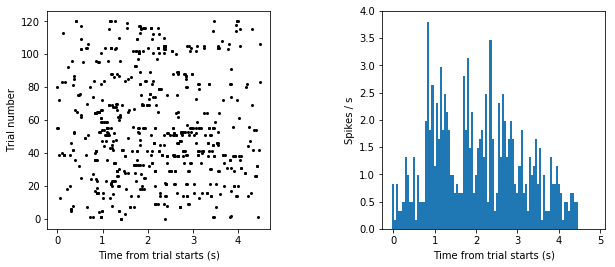

In [13]:
fig1cd, ax = plt.subplots(1, 2, figsize=(10, 4))
fig1cd.subplots_adjust(wspace=0.5)
ax[0].plot(spike_times, trial_idx , '.k', markersize=4)
ax[1].bar(spk_edges, spk_rates, width=0.05);
ax[0].set_ylabel('Trial number')
ax[0].set_xlabel('Time from trial starts (s)')
ax[1].set_xlabel('Time from trial starts (s)')
ax[1].set_ylabel('Spikes / s');

### Figure 1E, F

Mostly similar to the procedure in reproducing Figure 1C & D, however, Figure 1E & F requires a few extra steps. The spike raster and spike histogram are no longer aligned to trial start, but to the first touch in the corresponding trial. 

Thus, per trial, we will extract (using `.fetch()`) the event named `first_lick`, and use this onset time to align the spike times.

In [14]:
# Specify segmentation setting to align to "first lick" event
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'first_lick',
                                                      'pre_stim_duration': 1,
                                                      'post_stim_duration': 4}).fetch1()

In [15]:
# get spike-train
spk, spk_timestamps = (intracellular.TrialSegmentedSpikeTrain & session_key & seg_param_key).fetch(
    'segmented_spike_train', 'segmented_spike_timestamps')
touchon = (behavior.TrialSegmentedBehavior & session_key & seg_param_key).fetch('segmented_touch_onset')
ephys_timestamps = np.linspace(-1*float(seg_param_key['pre_stim_duration']),
                               float(seg_param_key['post_stim_duration']),
                               spk[0].size)

Here, we compute the touch duration per trial, and sort the trials based on touch duration

In [16]:
# get touch duration (last-touch - first-touch)
touch_dur = [np.diff(np.where(r > 0)[0][[0, -1]])[0] if np.where(r > 0)[0].size > 0 else -1 for r in touchon]

In [17]:
# sort trials based on touch duration
spk = spk[np.argsort(touch_dur)]

In [18]:
# restructure data for spike raster  
trial_idx, spike_times = zip(*((np.full_like(r, ri), r)
                                        for ri, r in enumerate(t[np.where(r > 0)[0]] for r, t in zip(spk, spk_timestamps))))
trial_idx = np.hstack(trial_idx)
spike_times = np.hstack(spike_times) 

In [19]:
tlim = -float(seg_param_key['pre_stim_duration']), float(seg_param_key['post_stim_duration'])
spk_rates, spk_edges = build_PSTH(spk, spk_timestamps, tlim, bin_size=0.001)

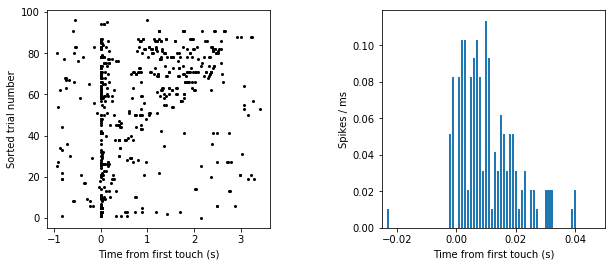

In [20]:
fig1ef, ax = plt.subplots(1, 2, figsize=(10, 4))
fig1ef.subplots_adjust(wspace=0.5)
ax[0].plot(spike_times, trial_idx , '.k', markersize=4)
ax[0].set_ylabel('Sorted trial number')
ax[0].set_xlabel('Time from first touch (s)')
ax[1].bar(spk_edges, spk_rates / 1000, width=0.0007);
ax[1].set_xlim((-0.025, 0.05));
ax[1].set_xlabel('Time from first touch (s)')
ax[1].set_ylabel('Spikes / ms');

## Figure 2 - Population response

Figure 2 requires splitting the recordings of cell population into the following categories:
+ L4 C2-inside
+ L4 C2-outside
+ L5 C2-inside

To achieve this, we will first construct queries to specifically select these cells. Note that this information is available in `intracellular.Cell` table because it refers back to specific location as enumerated in `reference.BrainLocation`.

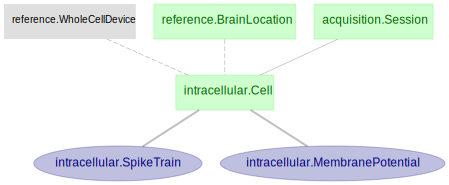

In [17]:
dj.Diagram(intracellular.Cell) + 1 - 1

In [23]:
l4_c2_inside_sess = intracellular.Cell & {'brain_subregion': 'C2', 'cortical_layer': 4}
l4_c2_outside_sess = intracellular.Cell & {'brain_subregion': 'surround', 'cortical_layer': 4}
l5_c2_inside_sess = intracellular.Cell & {'brain_subregion': 'C2', 'cortical_layer': 5}

Let's quickly check how many cells fall into each group.

In [24]:
print(f'Number of L4 C2-inside cells: {len(l4_c2_inside_sess)}')
print(f'Number of L4 C2-outside cells: {len(l4_c2_outside_sess)}')
print(f'Number of L5 C2-inside cells: {len(l5_c2_inside_sess)}')

Number of L4 C2-inside cells: 31
Number of L4 C2-outside cells: 10
Number of L5 C2-inside cells: 11


### Prepare to plot figure 2A
Here we plot the population mean PSTH for 3 unit groups fetched above, aligned to the onset of `pole move in`.

***Note***: this is slightly different from Figure 2A in the paper, in which data are aligned to `pole available`.

In [25]:
# Specify segmentation setting to align to "pole in" event
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'pole_in',
                                                      'pre_stim_duration': 0.5,
                                                      'post_stim_duration': 3}).fetch1()

In [26]:
# get spike-train from all trials from all cells - population level
l4_c2_inside_spk, l4_c2_inside_times = (intracellular.TrialSegmentedSpikeTrain & l4_c2_inside_sess & seg_param_key).fetch(
    'segmented_spike_train', 'segmented_spike_timestamps')
l4_c2_outside_spk, l4_c2_outside_times = (intracellular.TrialSegmentedSpikeTrain & l4_c2_outside_sess & seg_param_key).fetch(
    'segmented_spike_train', 'segmented_spike_timestamps')
l5_c2_inside_spk, l5_c2_inside_times = (intracellular.TrialSegmentedSpikeTrain & l5_c2_inside_sess & seg_param_key).fetch(
    'segmented_spike_train', 'segmented_spike_timestamps')

In [27]:
tlim = -float(seg_param_key['pre_stim_duration']), float(seg_param_key['post_stim_duration'])

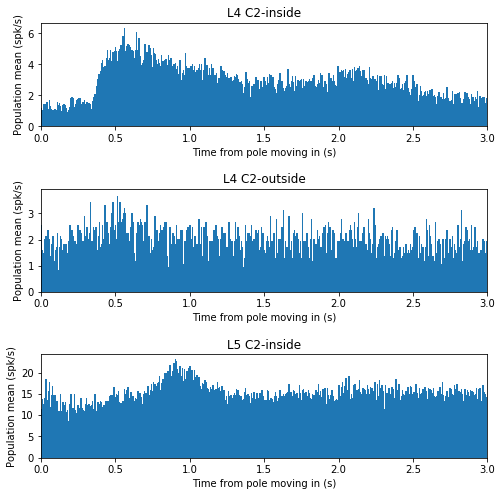

In [30]:
fig2a, axs = plt.subplots(3, 1, figsize=(8, 8))
fig2a.subplots_adjust(hspace=0.6)
for ax, spike_train, timestamps, title in zip(axs, (l4_c2_inside_spk, l4_c2_outside_spk, l5_c2_inside_spk),
                                              (l4_c2_inside_times, l4_c2_outside_times, l5_c2_inside_times),
                                              ('L4 C2-inside', 'L4 C2-outside', 'L5 C2-inside')):
    spk_rates, spk_edges = build_PSTH(spike_train, timestamps, tlim, bin_size=0.006)
    ax.bar(spk_edges, spk_rates, width=0.01)
    ax.set_xlim((0, 3))
    ax.set_title(title);
    ax.set_ylabel('Population mean (spk/s)')
    ax.set_xlabel('Time from pole moving in (s)');

### Prepare to plot figure 2B

Figure 2B depicts peri-stimulus time histogram aligned to `first touch`. 

To this end, we need to fetch trial-segmented spikes aligned to `trial start` (this is already precomputed), and then perform realighment to `first touch`. 

The function below, `build_realigned_PSTH()`, is defined to accomplish this task

In [31]:
# trial-average spike histogram
def build_realigned_PSTH(spike_train, spk_timestamps, event_data, event_timestamps, timerange, tlim, bin_size=0.05):
    spike_times = []
    for spikes, spk_t, events, event_t in zip(spike_train, spk_timestamps, event_data, event_timestamps):
        if (events > 0).any():
            first_eve = event_t[events == 1][0]
            aligned_spk = (spk_t - first_eve)[spikes > 0] 
            spike_times.append(aligned_spk)
    
    if spike_times:
        spk_counts, spk_edges = np.histogram(np.hstack(spike_times),
                                             bins=int((tlim[-1] - tlim[0]) / bin_size), range=tlim)
        spk_rates = spk_counts / np.diff(spk_edges) / len(spike_times)
        spk_edges = spk_edges[1:] 
        
        # normalize
        spk_rates = spk_rates / np.nanmax(spk_rates)
        
        return spk_rates, spk_edges
    else:
        return None, None

In [32]:
# Specify segmentation setting to align to "trial_start" event
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'trial_start',
                                                      'pre_stim_duration': 0,
                                                      'post_stim_duration': 4.9}).fetch1()

In [33]:
# get spike-train from all trials from all cells - population level
l4_c2_inside_spk = [(intracellular.TrialSegmentedSpikeTrain * behavior.TrialSegmentedBehavior & s & seg_param_key).fetch(
    'segmented_spike_train', 'segmented_spike_timestamps', 'segmented_touch_onset', 'segmented_behavior_timestamps')
                    for s in l4_c2_inside_sess.fetch('KEY', order_by='session_id')]
l4_c2_outside_spk = [(intracellular.TrialSegmentedSpikeTrain * behavior.TrialSegmentedBehavior & s & seg_param_key).fetch(
    'segmented_spike_train', 'segmented_spike_timestamps', 'segmented_touch_onset', 'segmented_behavior_timestamps')
                     for s in l4_c2_outside_sess.fetch('KEY', order_by='session_id')]
l5_c2_inside_spk = [(intracellular.TrialSegmentedSpikeTrain * behavior.TrialSegmentedBehavior & s & seg_param_key).fetch(
    'segmented_spike_train', 'segmented_spike_timestamps', 'segmented_touch_onset', 'segmented_behavior_timestamps')
                    for s in l5_c2_inside_sess.fetch('KEY', order_by='session_id')]

In [34]:
tlim=(-0.025, 0.05)
population_psth = []
cell_spk_edge = None
for unit_group in (l4_c2_inside_spk, l4_c2_outside_spk, l5_c2_inside_spk):
    # compute PSTH for population level
    PSTH_matrix = [build_realigned_PSTH(spk_train, spk_times, touch_onsets, behav_times, timerange=(-1*float(seg_param_key['pre_stim_duration']),
                               float(seg_param_key['post_stim_duration'])), tlim=tlim, bin_size=0.0005)
                   for spk_train, spk_times, touch_onsets, behav_times in unit_group if spk_train.size > 0]

    # obtain unit psth
    cell_spk_edge = PSTH_matrix[0][1] if cell_spk_edge is None else cell_spk_edge
    # per-unit normalization
    cell_spk_rate = np.vstack([s[0] for s in PSTH_matrix]) 

    population_psth.append(cell_spk_rate)
    population_psth.append(np.full((1, cell_spk_rate.shape[1]), np.nan))

In [35]:
population_psth = np.vstack(population_psth)

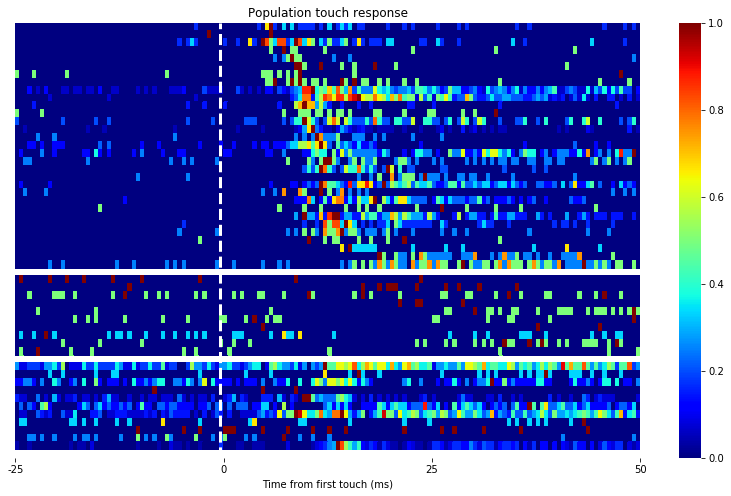

In [42]:
fig2b, ax = plt.subplots(1, 1, figsize=(14, 8))
sns.heatmap(population_psth, cmap='jet', ax=ax, xticklabels=[], yticklabels=[])

ax.axvline(x=np.where(np.abs(cell_spk_edge-0)<1e-15)[0][0], color='w',linestyle='--',linewidth=3)
ax.set_xticks([0, 50, 100, 150])
ax.set_xticklabels([-25, 0, 25, 50])

ax.set_title('Population touch response')
ax.set_xlabel('Time from first touch (ms)');